     Epoch     |    Train accuracy  |       Test accuracy  
              0|              0.1294|               0.127
              1|              0.9204|               0.898
              2|              0.9623|               0.932
              3|              0.9793|               0.936
              4|              0.9856|               0.939
              5|              0.9897|               0.937
              6|               0.993|               0.945
              7|              0.9947|               0.941
              8|              0.9924|               0.943
              9|              0.9957|               0.953
             10|              0.9969|               0.949
             11|              0.9989|               0.951
             12|              0.9994|               0.956
             13|               0.997|                0.95
             14|              0.9976|               0.952


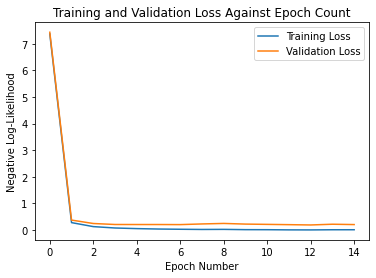

In [3]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam
import os
import sys
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# path to data
sys.path.append(os.path.join(os.getcwd(), "../../../data"))
from data_utils import load_dataset


def init_randn(m, n, rs=npr.RandomState(0)):
    """ init mxn matrix using small random normal
    """
    return 0.1 * rs.randn(m, n)


def init_xavier(m, n, rs=npr.RandomState(0)):
    """ TODO: init mxn matrix using Xavier intialization
    """
    return (1 / np.sqrt(n)) * rs.randn(m,n)


def init_net_params(layer_sizes, init_fcn, rs=npr.RandomState(0)):
    """ inits a (weights, biases) tuples for all layers using the intialize function (init_fcn)"""
    return [
        (init_fcn(m, n), np.zeros(n))  # weight matrix  # bias vector
        for m, n in zip(layer_sizes[:-1], layer_sizes[1:])
    ]


def relu(x):
    return np.maximum(0, x)


def neural_net_predict(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = relu(outputs)
    return outputs - logsumexp(outputs, axis=1, keepdims=True)


def mean_log_like(params, inputs, targets):
    """ TODO: return the log-likelihood / the number of inputs 
    """
    log_probabilities = neural_net_predict(params, inputs)
    num_inputs = len(inputs)
    return np.sum(targets * log_probabilities) / num_inputs


def accuracy(params, inputs, targets):
    """ return the accuracy of the neural network defined by params
    """
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(neural_net_predict(params, inputs), axis=1)
    return np.mean(predicted_class == target_class)


if __name__ == "__main__":
    # ----------------------------------------------------------------------------------
    # EXAMPLE OF HOW TO USE STARTER CODE BELOW
    # ----------------------------------------------------------------------------------

    # loading data
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset("mnist_small")

    # initializing parameters
    layer_sizes = [784, 750, 10] # 784, 200, 10
    params = init_net_params(layer_sizes, init_randn)

    # setting up training parameters
    num_epochs = 15 # 10
    learning_rate = 1e-2 # 1e-1
    batch_size = 256 # 256

    # Constants for batching
    num_batches = int(np.ceil(len(x_train) / batch_size))
    rind = np.arange(len(x_train))
    npr.shuffle(rind)

    def batch_indices(iter):
        idx = iter % num_batches
        return rind[slice(idx * batch_size, (idx + 1) * batch_size)]

    # Define training objective
    def objective(params, iter):
        # get indices of data in batch
        idx = batch_indices(iter)
        return -mean_log_like(params, x_train[idx], y_train[idx])

    # Get gradient of objective using autograd.
    objective_grad = grad(objective)

    print("     Epoch     |    Train accuracy  |       Test accuracy  ")

    # Dictionary to store train/val history
    opt_history = {
        "train_nll": [],
        "val_nll": [],
    }

    def callback(params, iter, gradient):
        if iter % num_batches == 0:
            # record training & val. accuracy every epoch
            opt_history["train_nll"].append(-mean_log_like(params, x_train, y_train))
            opt_history["val_nll"].append(-mean_log_like(params, x_valid, y_valid))
            train_acc = accuracy(params, x_train, y_train)
            val_acc = accuracy(params, x_valid, y_valid)
            print("{:15}|{:20}|{:20}".format(iter // num_batches, train_acc, val_acc))

    # We will optimize using Adam (a variant of SGD that makes better use of
    # gradient information).
    opt_params = adam(
        objective_grad,
        params,
        step_size=learning_rate,
        num_iters=num_epochs * num_batches,
        callback=callback,
    )

    # Plotting the train and validation negative log-likelihood
    plt.plot(opt_history["train_nll"])
    plt.plot(opt_history["val_nll"])
    plt.title('Training and Validation Loss Against Epoch Count')
    plt.xlabel('Epoch Number')
    plt.ylabel('Negative Log-Likelihood')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()


### Procedure for Tuning
- increase layer size
- If the accuracy needs more time to converge, increase number of epochs
- otherwise: increase layer size by 10
- If layer size exceeds ~1000, decrease learning rate by a factor of 10 and reset epoch number to 10 and layer size to 200

### Confusion Matrix

Final accuracy on the test set with chosen parameters: 0.961


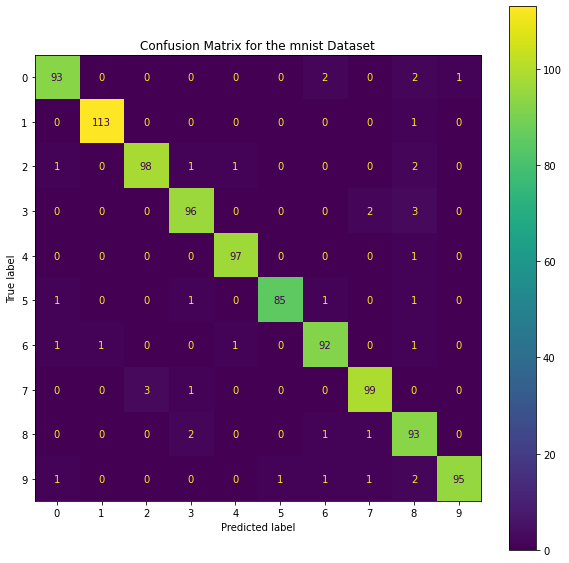

: 

In [4]:
inputs = x_test
targets = y_test
target_class = np.argmax(targets, axis=1)
predicted_class = np.argmax(neural_net_predict(opt_params, inputs), axis=1)
print("Final accuracy on the test set with chosen parameters:", np.mean(predicted_class == target_class))

matrix = ConfusionMatrixDisplay(confusion_matrix(target_class, predicted_class))
fig, ax = plt.subplots(figsize=(10,10))
matrix.plot(ax=ax)
plt.title('Confusion Matrix for the mnist Dataset')
plt.show()